<a href="https://colab.research.google.com/github/LucianaAngrisano/TriagemProcessual/blob/main/AU_KNN_3_colunas_Final_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Teste MODELO KNN

## Obtenção do dataframe

In [1]:
# monta o Google Drive para acesso pelo Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Cria objeto com o caminho da pasta do Projeto
from pathlib import Path
pasta_projeto = Path('drive/MyDrive/Colab Notebooks/Projeto')

In [3]:
# Cria o DataFrame a partir dos dados salvos no primeiro Caderno
import pandas as pd
df = pd.read_parquet(pasta_projeto / 'AU final.parquet')
print(df.shape)
df.head(3)
df['Setor_Sigla'].value_counts()

(14520, 4)


COREJEF1R    10106
CORESA1R      2457
CORESP1R      1266
CORESE1R       394
COREM1R        124
CORAT1R         94
COREPAM1R       79
Name: Setor_Sigla, dtype: int64

# Separação das variáveis independentes e depentende (TARGET)




In [4]:
# define variaveis independentes e variável dependente(TARGET)
X = df[['peticao','Tipo_Assunto_Nome','Classe_Processo_Nome']]
y = df['Setor_Sigla']

# Codificação das variáveis independentes (categórica + texto)

In [5]:
# Transformação das variáveis independentes categórica para numérica
X_train_dum = pd.get_dummies(X[['Tipo_Assunto_Nome','Classe_Processo_Nome']])
X_train_dum.shape

(14520, 443)

In [6]:
# mostra o dataframe da variável texto com as variáveis categóricas já tratadas
X = pd.concat([X['peticao'], X_train_dum], axis=1)
X.head()

,peticao,Tipo_Assunto_Nome_ CONCURSO DE MILITAR,Tipo_Assunto_Nome_ PRAZO,Tipo_Assunto_Nome_1/3 DE FÉRIAS,Tipo_Assunto_Nome_ABATIMENTO PROPORCIONAL DO PREÇO,Tipo_Assunto_Nome_ABONO DA LEI 8.178/91,Tipo_Assunto_Nome_ABONO DE PERMANÊNCIA,Tipo_Assunto_Nome_ABONO DE PERMANÊNCIA EM SERVIÇO (ART. 87),Tipo_Assunto_Nome_ABONO PECUNIÁRIO (ART. 78 LEI 8.112/1990),Tipo_Assunto_Nome_ACIDENTE DE TRÂNSITO,Tipo_Assunto_Nome_ACOMPANHAMENTO DE CÔNJUGE OU COMPANHEIRO,Tipo_Assunto_Nome_ACUMULAÇÃO DE CARGOS,Tipo_Assunto_Nome_ACUMULAÇÃO DE PROVENTOS,Tipo_Assunto_Nome_ADICIONAL DE FRONTEIRA,Tipo_Assunto_Nome_ADICIONAL DE HORAS EXTRAS,Tipo_Assunto_Nome_ADICIONAL DE INSALUBRIDADE,Tipo_Assunto_Nome_ADICIONAL DE PRODUTIVIDADE,Tipo_Assunto_Nome_ADICIONAL DE SERVIÇO NOTURNO,Tipo_Assunto_Nome_ADICIONAL DE TARIFA AEROPORTUÁRIA,Tipo_Assunto_Nome_ADICIONAL POR TEMPO DE SERVIÇO,Tipo_Assunto_Nome_ADIMPLEMENTO E EXTINÇÃO,Tipo_Assunto_Nome_ADJUDICAÇÃO,Tipo_Assunto_Nome_ADMISSÃO / PERMANÊNCIA / DESPEDIDA,Tipo_Assunto_Nome_ADVERTÊNCIA,Tipo_Assunto_Nome_ADVERTÊNCIA / REPREENSÃO,Tipo_Assunto_Nome_AGREGAÇÃO,Tipo_Assunto_Nome_AGÊNCIAS/ÓRGÃOS DE REGULAÇÃO,Tipo_Assunto_Nome_AGÊNCIE E DISTRIBUIÇÃO,Tipo_Assunto_Nome_ALIENAÇÃO FIDUCIÁRIA,Tipo_Assunto_Nome_ALTERAÇÃO DO COEFICIENTE DE CÁLCULO DE PENSÃO,Tipo_Assunto_Nome_ALTERAÇÃO DO COEFICIENTE DE CÁLCULO DO BENEFÍCIO,Tipo_Assunto_Nome_AMBIENTAL,Tipo_Assunto_Nome_ANISTIA ADMINISTRATIVA,Tipo_Assunto_Nome_ANISTIA POLÍTICA,Tipo_Assunto_Nome_ANULAÇÃO,Tipo_Assunto_Nome_ANULAÇÃO E CORREÇÃO DE PROVAS / QUESTÕES,Tipo_Assunto_Nome_APLICAÇÃO DE COEFICIENTE DE CÁLCULO DIVERSO DO FIXADO NA LEI N.º 8.213/91,Tipo_Assunto_Nome_APOSENTADORIA,Tipo_Assunto_Nome_APOSENTADORIA / PENSÃO ESPECIAL,Tipo_Assunto_Nome_APOSENTADORIA ESPECIAL (ART. 57/8),...,Classe_Processo_Nome_AÇÃO CIVIL PÚBLICA,Classe_Processo_Nome_AÇÃO POPULAR,Classe_Processo_Nome_CARTA PRECATÓRIA CRIMINAL,Classe_Processo_Nome_CARTA PRECATÓRIA CÍVEL,Classe_Processo_Nome_CONSIGNATÓRIA DE ALUGUÉIS,Classe_Processo_Nome_CONSIGNAÇÃO EM PAGAMENTO,Classe_Processo_Nome_CUMPRIMENTO DE SENTENÇA,Classe_Processo_Nome_CUMPRIMENTO DE SENTENÇA CONTRA A FAZENDA PÚBLICA,Classe_Processo_Nome_CUMPRIMENTO PROVISÓRIO DE DECISÃO,Classe_Processo_Nome_CUMPRIMENTO PROVISÓRIO DE SENTENÇA,Classe_Processo_Nome_DESAPROPRIAÇÃO,Classe_Processo_Nome_EMBARGOS DE TERCEIRO,Classe_Processo_Nome_EMBARGOS À EXECUÇÃO,Classe_Processo_Nome_EMBARGOS À EXECUÇÃO FISCAL,Classe_Processo_Nome_EXECUÇÃO CONTRA A FAZENDA PÚBLICA,Classe_Processo_Nome_EXECUÇÃO DE TÍTULO EXTRAJUDICIAL,Classe_Processo_Nome_EXECUÇÃO FISCAL,Classe_Processo_Nome_EXIBIÇÃO DE DOCUMENTO OU COISA,Classe_Processo_Nome_HABEAS DATA,Classe_Processo_Nome_HOMOLOGAÇÃO DE TRANSAÇÃO EXTRAJUDICIAL,Classe_Processo_Nome_IMISSÃO NA POSSE,Classe_Processo_Nome_INCIDENTE DE DESCONSIDERAÇÃO DE PERSONALIDADE JURÍDICA,Classe_Processo_Nome_INQUÉRITO POLICIAL,Classe_Processo_Nome_INTERDITO PROIBITÓRIO,Classe_Processo_Nome_LIQUIDAÇÃO POR ARTIGOS,Classe_Processo_Nome_LIQUIDAÇÃO PROVISÓRIA POR ARTIGOS,Classe_Processo_Nome_MANDADO DE SEGURANÇA,Classe_Processo_Nome_MANDADO DE SEGURANÇA COLETIVO,Classe_Processo_Nome_MONITÓRIA,Classe_Processo_Nome_OUTROS PROCEDIMENTOS DE JURISDIÇÃO VOLUNTÁRIA,Classe_Processo_Nome_PETIÇÃO,Classe_Processo_Nome_PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL,Classe_Processo_Nome_PROCEDIMENTO ORDINÁRIO,Classe_Processo_Nome_PRODUÇÃO ANTECIPADA DE PROVAS,Classe_Processo_Nome_PROTESTO,Classe_Processo_Nome_RECURSO INOMINADO,Classe_Processo_Nome_REINTEGRAÇÃO / MANUTENÇÃO DE POSSE,Classe_Processo_Nome_TUTELA ANTECIPADA ANTECEDENTE,Classe_Processo_Nome_TUTELA CAUTELAR ANTECEDENTE,Classe_Processo_Nome_USUCAPIÃO
0,Petição segue anexa.\n \nNum. 751512049 - Pág....,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,9254-20.2010.4.01.3803 \nEXMO (A) SR (A) JUIZ ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0

In [7]:
# importação das bibliotecas necessárias para tratamento da variável de texto
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
# Separação dos dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)

In [9]:
# Tratamento dos dados de treino textual 
tfidf = TfidfVectorizer(stop_words=stopwords.words('portuguese'), min_df=3, max_df=0.70, max_features=1000)

# Aprende vocabulário e idf do conjunto de treinamento
tfidf.fit(X_train['peticao'])

#Transforma documentos em matriz termo-documento.
X_train_tfidf = tfidf.transform(X_train['peticao'])
X_test_tfidf = tfidf.transform(X_test['peticao'])

In [10]:
# tratamento do test
# após a transformação do texto usamos o todense para armazenar valores ausentes na série (quando nao encontrou a palavra na petição retornou "naN")
X_test_tfidf = pd.DataFrame(X_test_tfidf.todense())
X_test_tfidf.index = X_test.index

In [11]:
# função concat para retirar a coluna de texto da petição , axis = 1 concatena colunas axis = 0 concatena linhas
X_test = pd.concat([X_test_tfidf, X_test.drop(columns='peticao')], axis=1)
X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,Classe_Processo_Nome_AÇÃO CIVIL PÚBLICA,Classe_Processo_Nome_AÇÃO POPULAR,Classe_Processo_Nome_CARTA PRECATÓRIA CRIMINAL,Classe_Processo_Nome_CARTA PRECATÓRIA CÍVEL,Classe_Processo_Nome_CONSIGNATÓRIA DE ALUGUÉIS,Classe_Processo_Nome_CONSIGNAÇÃO EM PAGAMENTO,Classe_Processo_Nome_CUMPRIMENTO DE SENTENÇA,Classe_Processo_Nome_CUMPRIMENTO DE SENTENÇA CONTRA A FAZENDA PÚBLICA,Classe_Processo_Nome_CUMPRIMENTO PROVISÓRIO DE DECISÃO,Classe_Processo_Nome_CUMPRIMENTO PROVISÓRIO DE SENTENÇA,Classe_Processo_Nome_DESAPROPRIAÇÃO,Classe_Processo_Nome_EMBARGOS DE TERCEIRO,Classe_Processo_Nome_EMBARGOS À EXECUÇÃO,Classe_Processo_Nome_EMBARGOS À EXECUÇÃO FISCAL,Classe_Processo_Nome_EXECUÇÃO CONTRA A FAZENDA PÚBLICA,Classe_Processo_Nome_EXECUÇÃO DE TÍTULO EXTRAJUDICIAL,Classe_Processo_Nome_EXECUÇÃO FISCAL,Classe_Processo_Nome_EXIBIÇÃO DE DOCUMENTO OU COISA,Classe_Processo_Nome_HABEAS DATA,Classe_Processo_Nome_HOMOLOGAÇÃO DE TRANSAÇÃO EXTRAJUDICIAL,Classe_Processo_Nome_IMISSÃO NA POSSE,Classe_Processo_Nome_INCIDENTE DE DESCONSIDERAÇÃO DE PERSONALIDADE JURÍDICA,Classe_Processo_Nome_INQUÉRITO POLICIAL,Classe_Processo_Nome_INTERDITO PROIBITÓRIO,Classe_Processo_Nome_LIQUIDAÇÃO POR ARTIGOS,Classe_Processo_Nome_LIQUIDAÇÃO PROVISÓRIA POR ARTIGOS,Classe_Processo_Nome_MANDADO DE SEGURANÇA,Classe_Processo_Nome_MANDADO DE SEGURANÇA COLETIVO,Classe_Processo_Nome_MONITÓRIA,Classe_Processo_Nome_OUTROS PROCEDIMENTOS DE JURISDIÇÃO VOLUNTÁRIA,Classe_Processo_Nome_PETIÇÃO,Classe_Processo_Nome_PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL,Classe_Processo_Nome_PROCEDIMENTO ORDINÁRIO,Classe_Processo_Nome_PRODUÇÃO ANTECIPADA DE PROVAS,Classe_Processo_Nome_PROTESTO,Classe_Processo_Nome_RECURSO INOMINADO,Classe_Processo_Nome_REINTEGRAÇÃO / MANUTENÇÃO DE POSSE,Classe_Processo_Nome_TUTELA ANTECIPADA ANTECEDENTE,Classe_Processo_Nome_TUTELA CAUTELAR ANTECEDENTE,Classe_Processo_Nome_USUCAPIÃO
705,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.158621,0.000000,0.000000,0.000000,0.000000,0.0,0.106575,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.135232,0.0,0.000000,0.000000,0.00000,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
11403,0.013298,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.051174,0.000000,0.106095,0.000000,0.000000,0.0,0.005494,0.101082,0.005764,0.087866,0.006052,0.005323,0.0,0.009433,0.0,0.000000,0.004973,0.0,0.000000,0.019222,0.000000,0.000000,0.000000,0.000000,0.032251,0.004488,0.0,0.000000,0.000000,0.00000,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6838,0.012017,0.000000,0.017321,0.0,0.0,0.000000,0.000000,0.000000,0.013168,0.000000,0.000000,0.000000,0.020777,0.092266,0.0,0.000000,0.011418,0.000000,0.011343,0.000000,0.014432,0.0,0.012786,0.0,0.227372,0.026966,0.0,0.000000,0.000000,0.046038,0.020946,0.000000,0.000000,0.024981,0.012168,0.0,0.000000,0.000000,0.00000,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
12871,0.000000,0.041613,0.000000,0.0,0.0,0.031270,0.000000,0.114328,0.000000,0.113452,0.019910,0.013177,0.009994,0.000000,0.0,0.007165,0.192238,0.007517,0.021826,0.007893,0.000000,0.0,0.000000,0.0,0.012867,0.006486,0.0,0.005932,0.000000,0.000000,0.000000,0.063788,0.008935,0.006008,0.000000,0.0,0.020238,0.044932,0.00000,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
5279,0.040511,0.000000,0.000000,0.0,0.0,0.021914,0.022463,0.000000,0.000000,0.000000,0.093016,0.438626,0.000000,0.088865,0.0,0.000000,0.000000,0.000000,0.076477,0.000000,0.000000,0.0,0.021551,0.0,0.067629,0.090901,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.03746,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0

In [12]:
# tratamento do treino
X_train_tfidf = pd.DataFrame(X_train_tfidf.todense())
X_train_tfidf.index = X_train.index

In [13]:
# tratamento do treino
X_train = pd.concat([X_train_tfidf, X_train.drop(columns='peticao')], axis=1)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,Classe_Processo_Nome_AÇÃO CIVIL PÚBLICA,Classe_Processo_Nome_AÇÃO POPULAR,Classe_Processo_Nome_CARTA PRECATÓRIA CRIMINAL,Classe_Processo_Nome_CARTA PRECATÓRIA CÍVEL,Classe_Processo_Nome_CONSIGNATÓRIA DE ALUGUÉIS,Classe_Processo_Nome_CONSIGNAÇÃO EM PAGAMENTO,Classe_Processo_Nome_CUMPRIMENTO DE SENTENÇA,Classe_Processo_Nome_CUMPRIMENTO DE SENTENÇA CONTRA A FAZENDA PÚBLICA,Classe_Processo_Nome_CUMPRIMENTO PROVISÓRIO DE DECISÃO,Classe_Processo_Nome_CUMPRIMENTO PROVISÓRIO DE SENTENÇA,Classe_Processo_Nome_DESAPROPRIAÇÃO,Classe_Processo_Nome_EMBARGOS DE TERCEIRO,Classe_Processo_Nome_EMBARGOS À EXECUÇÃO,Classe_Processo_Nome_EMBARGOS À EXECUÇÃO FISCAL,Classe_Processo_Nome_EXECUÇÃO CONTRA A FAZENDA PÚBLICA,Classe_Processo_Nome_EXECUÇÃO DE TÍTULO EXTRAJUDICIAL,Classe_Processo_Nome_EXECUÇÃO FISCAL,Classe_Processo_Nome_EXIBIÇÃO DE DOCUMENTO OU COISA,Classe_Processo_Nome_HABEAS DATA,Classe_Processo_Nome_HOMOLOGAÇÃO DE TRANSAÇÃO EXTRAJUDICIAL,Classe_Processo_Nome_IMISSÃO NA POSSE,Classe_Processo_Nome_INCIDENTE DE DESCONSIDERAÇÃO DE PERSONALIDADE JURÍDICA,Classe_Processo_Nome_INQUÉRITO POLICIAL,Classe_Processo_Nome_INTERDITO PROIBITÓRIO,Classe_Processo_Nome_LIQUIDAÇÃO POR ARTIGOS,Classe_Processo_Nome_LIQUIDAÇÃO PROVISÓRIA POR ARTIGOS,Classe_Processo_Nome_MANDADO DE SEGURANÇA,Classe_Processo_Nome_MANDADO DE SEGURANÇA COLETIVO,Classe_Processo_Nome_MONITÓRIA,Classe_Processo_Nome_OUTROS PROCEDIMENTOS DE JURISDIÇÃO VOLUNTÁRIA,Classe_Processo_Nome_PETIÇÃO,Classe_Processo_Nome_PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL,Classe_Processo_Nome_PROCEDIMENTO ORDINÁRIO,Classe_Processo_Nome_PRODUÇÃO ANTECIPADA DE PROVAS,Classe_Processo_Nome_PROTESTO,Classe_Processo_Nome_RECURSO INOMINADO,Classe_Processo_Nome_REINTEGRAÇÃO / MANUTENÇÃO DE POSSE,Classe_Processo_Nome_TUTELA ANTECIPADA ANTECEDENTE,Classe_Processo_Nome_TUTELA CAUTELAR ANTECEDENTE,Classe_Processo_Nome_USUCAPIÃO
3470,0.044333,0.000000,0.000000,0.000000,0.0,0.015988,0.000000,0.204584,0.000000,0.000000,0.000000,0.000000,0.025550,0.000000,0.027215,0.000000,0.000000,0.000000,0.097642,0.000000,0.124228,0.0,0.015723,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028306,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
8186,0.032730,0.000000,0.047173,0.000000,0.0,0.017705,0.018148,0.032365,0.000000,0.000000,0.000000,0.000000,0.000000,0.143593,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.034824,0.000000,0.036427,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.016570,0.052963,0.00000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
13548,0.000000,0.000000,0.000000,0.000000,0.0,0.012539,0.032132,0.017191,0.019049,0.006690,0.325981,0.019813,0.000000,0.006356,0.021344,0.007182,0.016518,0.007535,0.032819,0.007912,0.006959,0.0,0.036993,0.000000,0.006449,0.006501,0.000000,0.017840,0.012564,0.000000,0.0101,0.000000,0.008957,0.018069,0.058675,0.000000,0.00000,0.033781,0.000000,0.024811,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3129,0.016553,0.006349,0.006258,0.016212,0.0,0.071634,0.029492,0.023346,0.148373,0.148808,0.029596,0.022578,0.006568,0.018156,0.004498,0.002691,0.038675,0.001411,0.047130,0.001482,0.034870,0.0,0.157644,0.019493,0.039564,0.017658,0.007753,0.021164,0.000588,0.010915,0.0000,0.000998,0.000839,0.003667,0.020058,0.002635,0.00095,0.003691,0.006022,0.016266,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
5003,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

# Treino e teste do modelo

In [14]:
# importa o modelo KNN
from sklearn.neighbors import KNeighborsClassifier

#instanciou o modelo
model = KNeighborsClassifier()

#treinou e testou o modelo
model.fit(X_train, y_train)
model.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


0.9765840220385675

In [15]:
#importou a biblioteca para medir a acurácia balanceada
from sklearn.metrics import balanced_accuracy_score

# mostrou o score da acurácia balanceado do modelo
print(balanced_accuracy_score(y_test, model.predict(X_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


0.8628192550043313


# Balanceamento das classes

In [16]:
# importa a biblioteca para balancear a variável target
from imblearn.over_sampling import RandomOverSampler

# para equilibrar o conjunto de dados que estão com pouca amostragem
# apenas nos dados de treino
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [17]:
y_resampled.value_counts()

CORESP1R     8085
COREPAM1R    8085
COREJEF1R    8085
CORESA1R     8085
COREM1R      8085
CORESE1R     8085
CORAT1R      8085
Name: Setor_Sigla, dtype: int64

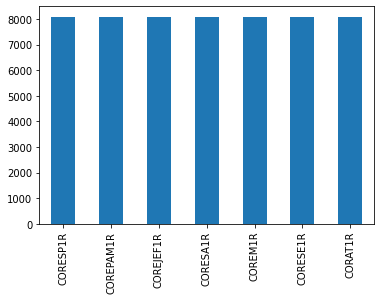

In [19]:
y_resampled.value_counts().plot(kind='bar',)

#Mostra o Classification Report de após o balanceamento das classes

In [20]:
# importa a biblioteca para visualização das métricas
from sklearn.metrics import classification_report

#instancia o modelo com as classes balanceadas
model_resampled = KNeighborsClassifier()

# Treina o modelo com os dados balanceados
model_resampled.fit(X_resampled, y_resampled)

# mostra a recall e macro avg = acurácia balanceada
print(classification_report(y_test, model_resampled.predict(X_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


              precision    recall  f1-score   support

     CORAT1R       0.76      0.68      0.72        19
   COREJEF1R       1.00      0.99      0.99      2021
     COREM1R       0.69      0.72      0.71        25
   COREPAM1R       0.75      0.75      0.75        16
    CORESA1R       0.95      0.99      0.97       491
    CORESE1R       0.83      0.80      0.81        79
    CORESP1R       0.91      0.92      0.92       253

    accuracy                           0.97      2904
   macro avg       0.84      0.84      0.84      2904
weighted avg       0.97      0.97      0.97      2904



In [21]:
# importa a métrica de acurácia balanceada 
from sklearn.metrics import balanced_accuracy_score
# mostra o valor da acurácia balanceada separadamente = macro avg do Classification Report
print(balanced_accuracy_score(y_test, model_resampled.predict(X_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


0.8353550254362736


#Matriz de Confusão

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


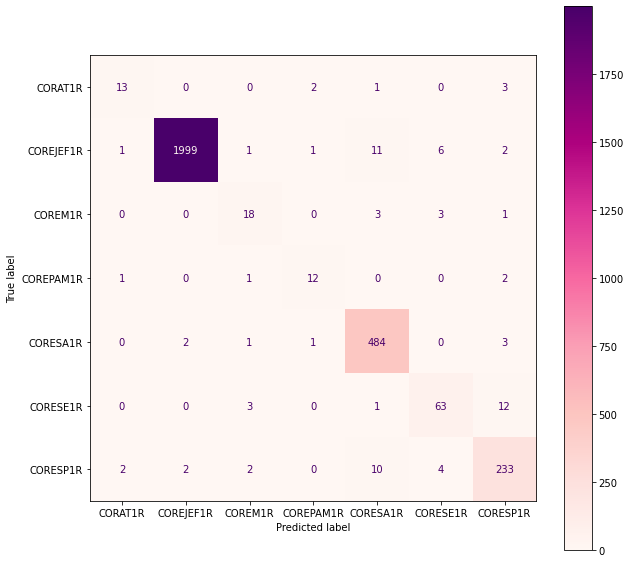

In [22]:
#importa a biblioteca para plotar a matriz de confusão
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
# define o tamanho do gráfico
fig, ax = plt.subplots(figsize=(10,10))
#plota a matriz de confusão passando os parâmetros do modelo, das variáveis e do tamanho do gráfico definidio anteriormente
plot_confusion_matrix(model_resampled, X_test, y_test, ax=ax, cmap='RdPu');

# GridSearch para definição dos melhores hiperparâmetros

In [23]:
#GridSearch para definir os melhores hiperparâmetros para otimizar o modelo

#from sklearn.model_selection import GridSearchCV

#model = KNeighborsClassifier()


# params = {'n_neighbors':[4,6],'p':[1,2] }
# grid_search = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=5, scoring='balanced_accuracy',error_score=0, verbose = 100)
# grid_search.fit(X_resampled,y_resampled)
# grid_search.best_params_


In [24]:
# importa KNN e Classification report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
# modelo treinado após definição dos melhores hiperparâmetros após GridSearch = n_neighbors=4, p=2
model = KNeighborsClassifier(n_neighbors=4, p=2)
model.fit(X_resampled, y_resampled)
print(classification_report(y_test, model.predict(X_test)))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


              precision    recall  f1-score   support

     CORAT1R       0.76      0.68      0.72        19
   COREJEF1R       1.00      0.99      0.99      2021
     COREM1R       0.69      0.72      0.71        25
   COREPAM1R       0.75      0.75      0.75        16
    CORESA1R       0.95      0.99      0.97       491
    CORESE1R       0.84      0.78      0.81        79
    CORESP1R       0.91      0.92      0.92       253

    accuracy                           0.97      2904
   macro avg       0.84      0.83      0.84      2904
weighted avg       0.97      0.97      0.97      2904



# Importância das variáveis (não se aplica para variável texto)

In [25]:
# tentativa de mostrar graficamente a importância das variáveis

##%%time
# Calcula a importância das variáveis
# Import a biblioteca (permutation_importance)
##from sklearn.inspection import permutation_importance
# Calcular os resultados (permutation_importance) da queda no desempenho do modelo 
#          ao embaralhar cada uma das variáveis.
#result = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)
# Ordenar os resultados
##sorted_idx = result.importances_mean.argsort()
# Gráfico boxplot pra mostrar a importância das variáveis
#fig, ax = plt.subplots()
#ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
#ax.set_title("Permutation Importances (test set)")
#fig.tight_layout()
#plt.show()